# Parking in Eindhoven, Data Analysis & Investigation

The city of Eindhoven has tons of available data. This is mostly comprised of geographic point locations combined with various other domains. This data by itself can provide some interesting insights into the city and its surroundings.

What is even more interesting that new 'hidden' information is uncovered when combining some of these domains.

In the upcoming sections the parking data will be analyzed, treated and displayed. The dataset contains the following:

* ID - Id of the object
* STREET - Street name
* TYPE - Type of parking spot (6 unique)
* COUNT - Number of available parking spots
* LON - Longitudinal coordinates
* LAT - Latitudal coordinates
* GEO_2D - Geolocation in 2D

The goal is to analyze the data and describe what steps are needed to succesfully recreate a scatter plot of parking spots from the city of Eindhoven.

Next to that a look will be taken at a different approach of importing data. (not csv dump but web api)

And finally ready the prepared dataset with a storage solution that can be used for ML algorithms.

## Importing the dataset

Firstly the dataset and standard libraries which are used frequently have to be imported.

De delimiter of the dataset is';' in this situation. This can be seen by opening the dataset.

The top datapoint from the dataset has been removed because it contained column information

In [11]:
import pandas as pd
import numpy as np

column_names = ['ID', 'STREET', 'TYPE', 'COUNT', 'LON', 'LAT', 'GEO_2D']
dataset = pd.read_csv("/Users/Matt/Desktop/AI/PersonalNotebooks/DAIA/Eindhoven Data/Ehvn_parking.csv", 
                      delimiter=';', names=column_names)
#dataset['ID'] = np.sort(dataset['ID'], 0)
dataset = dataset.iloc[1:, :]
dataset.head()

,ID,STREET,TYPE,COUNT,LON,LAT,GEO_2D
1,5869,Winkelcentrum Woensel,Parkeerplaats,1,"5,473875387","51,46894486","51,4689448625;5,47387538744"
2,5873,Winkelcentrum Woensel,Parkeerplaats,1,"5,472963547","51,46882236","51,4688223571;5,47296354721"
3,5874,Winkelcentrum Woensel,Parkeerplaats,1,"5,472994225","51,4688196","51,468819602;5,4729942254"
4,5875,Winkelcentrum Woensel,Parkeerplaats,1,"5,473027096","51,46881958","51,4688195778;5,47302709629"
5,5876,Winkelcentrum Woensel,Parkeerplaats,1,"5,47306434","51,46881818","51,468818175;5,47306433969"


By printing the shape of the dataset we can see that it contains 11337 items.

In [12]:
dataset.shape

(11337, 7)

## Compostion of the dataset

To get a more specific look into the composition of the dataset we call the describe function. 

With this we can see the spread of data.

In [13]:
dataset.describe()

,ID,STREET,TYPE,COUNT,LON,LAT,GEO_2D
count,11337,11337,11337,11337,11337,11337,11337
unique,11337,175,6,1,11312,11293,11314
top,2983,Winkelcentrum Woensel,Parkeerplaats,1,"5,474904981","51,4303056","51,4339875835;5,47479344564"
freq,1,1904,10260,11337,2,2,2


From the table above we can see that:
1. There are 175 unique street adresses
2. There are 6 types of parking spot
3. Each datapoint is 1 parking spot

Checking for null values is another important step. These can have a negative impact on the accuracy of the model. 
Also we could run into some difficulties when performing mutations.

In [14]:
dataset.isnull().sum()

ID        0
STREET    0
TYPE      0
COUNT     0
LON       0
LAT       0
GEO_2D    0
dtype: int64

Luckily there are no null values. 

But this does not mean that the data meets all standards. Lets take a closer look.

## Treating the dataset

From the composition of the dataset we deduced there are 175 different streets, and over 11k parking spots. It would be a difficult task to plot all 11k points. 

We will take each street as a single point, and the weight will be dependent on the count of parking spots in that street.

Lets see the count of each street.

In [15]:
dataset['STREET'].value_counts()

Winkelcentrum Woensel            1904
Niet ingevuld                     731
Bomanshof                         295
Veldmaarschalk Montgomerylaan     281
Professor Dr Dorgelolaan          248
                                 ... 
Korte Havenstraat                   3
Houtstraat                          3
Burgemeester Vogelspad              2
Molenveld                           1
Boschdijk                           1
Name: STREET, Length: 175, dtype: int64

We can see that there is one street which is a little suspicious. 'Niet ingevuld' means that this field has not been filled in.

These datapoints will be removed from the dataset for now. Later on they will be plotted individually with a different color of representation compared to the streets.

In [16]:
unknown_street_parking = [d for d in dataset['STREET'] if d == 'Niet ingevuld']

#pandas.Dateframe.isin will return boolean values depending on whether 
#each element is inside the list a or not. You then invert this with 
#the ~ to convert True to False and vice versa.
dataset = dataset[~dataset['STREET'].isin(unknown_street_parking)]
        
street_count = dataset['STREET'].value_counts()
street_count.head()

Winkelcentrum Woensel            1904
Bomanshof                         295
Veldmaarschalk Montgomerylaan     281
Professor Dr Dorgelolaan          248
Woenselse Markt                   239
Name: STREET, dtype: int64

Now that we have the parking count of each street. we can apply this later to the coordinates of each street.

To calculate the mean coordinates of each street the dataset will be grouped and a mean will be determined.

By opening the dataset in Excel I noticed that the structure was a little off. So lets check the type of LON and LAT, If we want to perform calculations on these they should be either a float or int.

In [17]:
type(dataset['LON'][1])

str

The type of LON and LAT is a string. It has to be converted to a float first. Also the decimal has to be replaced by a point.

In [18]:
dataset['LON'] = dataset['LON'].str.replace(',', '.').astype(float)
dataset['LAT'] = dataset['LAT'].str.replace(',', '.').astype(float)
dataset.head()

,ID,STREET,TYPE,COUNT,LON,LAT,GEO_2D
1,5869,Winkelcentrum Woensel,Parkeerplaats,1,5.473875,51.468945,"51,4689448625;5,47387538744"
2,5873,Winkelcentrum Woensel,Parkeerplaats,1,5.472964,51.468822,"51,4688223571;5,47296354721"
3,5874,Winkelcentrum Woensel,Parkeerplaats,1,5.472994,51.468820,"51,468819602;5,4729942254"
4,5875,Winkelcentrum Woensel,Parkeerplaats,1,5.473027,51.468820,"51,4688195778;5,47302709629"
5,5876,Winkelcentrum Woensel,Parkeerplaats,1,5.473064,51.468818,"51,468818175;5,47306433969"


For now we are only interested in few columns. Namely: STREET, LON, LAT and the total count of grouped streets which we will cal TOTAL.

The rest will be dropped from the table. And a mean will be calculated for both the LON and LAT coordinates.

In [23]:
combo_arr = dataset.drop(['TYPE', 'COUNT', 'GEO_2D', 'ID'], axis=1)
        
grouped_combo = combo_arr.groupby(['STREET']).mean()
grouped_combo['TOTAL'] = street_count
grouped_combo

,LON,LAT,TOTAL
STREET,,,
Aalsterweg,5.486350,51.426629,89
Acaciastraat,5.455077,51.444660,37
Adriaan Mulderweg,5.396767,51.453249,52
Aert Roelofsstraat,5.486266,51.438990,5
Akkerstraat,5.474520,51.432661,39
...,...,...,...
Wouter Hollemanplein,5.463745,51.438419,41
Zanddreef,5.407306,51.446949,29
Zwaanstraat,5.451118,51.448693,19


Finally with the dataset we have created a graph can be plotted. Because the data is scattered across several areas of concentraion, the 'scatter plot' will be used.

<AxesSubplot:xlabel='LON', ylabel='LAT'>

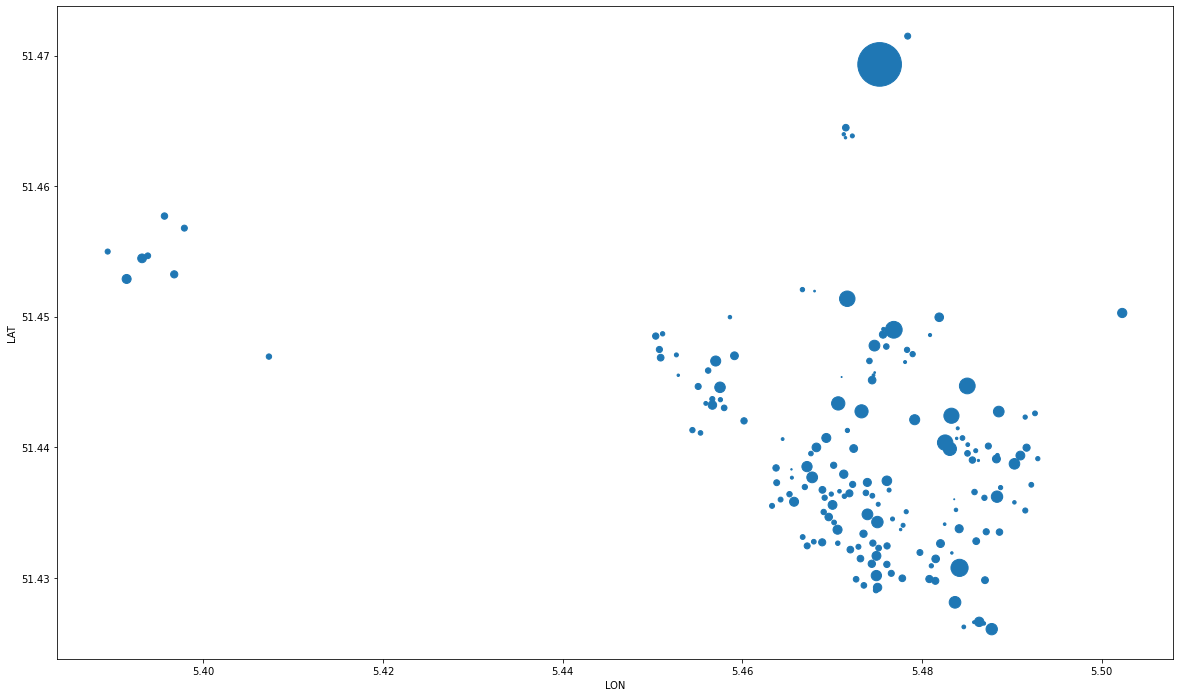

In [22]:
grouped_combo.plot(x='LON', y='LAT', s='TOTAL', kind='scatter', 
                   colormap="hot_r", figsize=[20, 12])